## SNAQ network inference for balanced tree simulations
Use nb6 tree distributions to run network inferences.

In [1]:
# check conda enviornment
import sys; sys.prefix

'/home/scarlet/miniconda3/envs/env20230724'

In [2]:
from pathlib import Path
import toytree
import toyplot, toyplot.svg, toyplot.color
import numpy as np
import pandas as pd
import itertools
import ipcoal
from concurrent.futures import ProcessPoolExecutor
import os

### Correct tree topologies

In [269]:
# get an ultrametric balanced tree
BALTREE = toytree.rtree.baltree(8, treeheight=1e6)
EDGES1 = [2,3,9,6,7,12]
EDGES2 = [2,3,9,10,6,7,12,13]
NE_DEFAULT = 5e5
GT_DEFAULT = 1
RNG = np.random.default_rng(123)
NLOCI = 10_000
NAME_ORDER = sorted(BALTREE.get_tip_labels())[::-1]
NAME_ORDER 

['r7', 'r6', 'r5', 'r4', 'r3', 'r2', 'r1', 'r0']

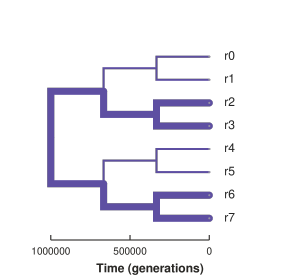

In [270]:
# VARY NE
# set parameters on the species tree
baltree_2_ne = BALTREE.copy()
# set root node dist value (node 14)
baltree_2_ne.set_node_data("dist", {14: 1e6/3}, inplace=True);

baltree_2_ne = baltree_2_ne.set_node_data("Ne", {i: NE_DEFAULT * 20 for i in EDGES2}, default=NE_DEFAULT)
baltree_2_ne = baltree_2_ne.set_node_data("gt", default=GT_DEFAULT)
baltree_2_ne = baltree_2_ne.set_node_data("tg", {i: i.dist / i.gt for i in baltree_2_ne})
baltree_2_ne = baltree_2_ne.set_node_data("tc", {i: i.tg / (2 * i.Ne) for i in baltree_2_ne})
baltree_2_ne = baltree_2_ne.set_node_data("theta", {i: 4 * i.Ne * 1e-8 for i in baltree_2_ne})
baltree_2_ne = baltree_2_ne.set_node_data("rho", {i: 4 * i.Ne * 1e-9 for i in baltree_2_ne})
baltree_2_ne = baltree_2_ne.set_node_data("tg_rho", {i: i.tg * i.rho for i in baltree_2_ne})
baltree_2_ne = baltree_2_ne.set_node_data("tg_theta", {i: i.tg * i.theta * 1e-9 for i in baltree_2_ne})

# convert edge lens to units of generations.
baltree_2_ne = baltree_2_ne.set_node_data("dist", {i: i.tg for i in baltree_2_ne})

# show data
baltree_2_ne.get_node_data()

kwargs = dict(
    scale_bar=True, tip_labels_align=True, 
    edge_widths=("Ne", 2, 7), edge_colors="gt", fixed_order=NAME_ORDER
)

# canvas for tree
c, a, m = baltree_2_ne.ladderize().draw(**kwargs)
a.x.label.text = "Time (generations)"
c

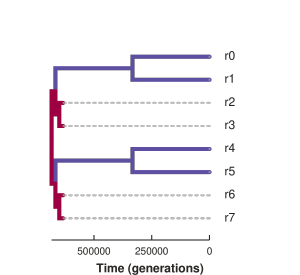

In [271]:
# VARY GT
baltree_2_gt = BALTREE.copy()
# set root node dist value (node 14)
baltree_2_gt.set_node_data("dist", {14: 1e6/3}, inplace=True);

baltree_2_gt = baltree_2_gt.set_node_data("Ne", default=NE_DEFAULT)
baltree_2_gt = baltree_2_gt.set_node_data("gt", {i: GT_DEFAULT * 20 for i in EDGES2}, default=GT_DEFAULT)
baltree_2_gt = baltree_2_gt.set_node_data("tg", {i: i.dist / i.gt for i in baltree_2_gt})
baltree_2_gt = baltree_2_gt.set_node_data("tc", {i: i.tg / (2 * i.Ne) for i in baltree_2_gt})
baltree_2_gt = baltree_2_gt.set_node_data("theta", {i: 4 * i.Ne * 1e-8 for i in baltree_2_gt})
baltree_2_gt = baltree_2_gt.set_node_data("rho", {i: 4 * i.Ne * 1e-9 for i in baltree_2_gt})
baltree_2_gt = baltree_2_gt.set_node_data("tg_rho", {i: i.tg * i.rho for i in baltree_2_gt})
baltree_2_gt = baltree_2_gt.set_node_data("tg_theta", {i: i.tg * i.theta * 1e-9 for i in baltree_2_gt})

# convert dist to units of generations. Draw and show data
baltree_2_gt = baltree_2_gt.set_node_data("dist", {i: i.tg for i in baltree_2_gt})
baltree_2_gt.get_node_data()

kwargs = dict(
    scale_bar=True, tip_labels_align=True, 
    edge_widths=("Ne", 2, 4), edge_colors="gt", fixed_order=NAME_ORDER
)
c, a, m = baltree_2_gt.ladderize().draw(**kwargs);
a.x.label.text = "Time (generations)"
c

### Input gene trees

### Linked: 50,000 trees simulated in nb6

In [6]:
superset_rax_df_ne2_1e3 = pd.read_csv("./nb6_output/superset-rax-df-ne2-1e3.csv")
superset_rax_df_gt2_1e3 = pd.read_csv("./nb6_output/superset-rax-df-gt2-1e3.csv")
superset_rax_df_ne2_1e5 = pd.read_csv("./nb6_output/superset-rax-df-ne2-1e5.csv")
superset_rax_df_gt2_1e5 = pd.read_csv("./nb6_output/superset-rax-df-gt2-1e5.csv")

superset_rax_df_ne2_1e3.head()

,Unnamed: 0,locus,start,end,nbps,nsnps,gene_tree
0,0,0,0,1000,1000,77,"((r6:0.009843,(((r4:0.00..."
1,1,1,0,1000,1000,110,"((r6:0.00909,((r0:0.0081..."
2,2,2,0,1000,1000,120,"(r6:0.016168,((r0:0.0119..."
3,3,3,0,1000,1000,107,"(r4:0.016555,(r7:0.02056..."
4,4,4,0,1000,1000,83,"((r0:0.00314,r1:0.005049..."


### Unlinked true genealogies simulated in nb6

In [100]:
superset_rax_df_true_ne_unlinked_bal = pd.read_csv("./nb6_output/superset-rax-df-true-ne-unlinked-bal.csv")
superset_rax_df_true_gt_unlinked_bal = pd.read_csv("./nb6_output/superset-rax-df-true-gt-unlinked-bal.csv")
superset_rax_df_true_gt_unlinked_bal.head()

,Unnamed: 0,locus,start,end,nbps,nsnps,tidx,genealogy
0,0,0,0,1,1,0,0,"((r0:754377.27607982093468,r7:121043.94274648767896):2414715.84067830769345,(r4:1378921.81854299129918,(r2:487253.44696556800045,(r1:901499.75340520590544,(r6:151873.54993451747578,(r3:89514.46667781274300,r5:722847.80001114599872):62359.08325670473278):116292.87013735517394):219087.02689369535074):258335.03824409004301):1790171.29821513732895);"
1,1,1,0,1,1,0,0,"((r0:913433.24032172793522,r5:913433.24032172793522):1482958.99664986971766,((r7:231875.46614937949926,(r4:725868.50344785524067,(r2:62525.02589524840005,r3:62525.02589524840005):30010.14421927358489):139340.29603485751431):546944.82671884750016,(r1:1107741.12393743824214,r6:474407.79060410498641):304412.50226412201300):984238.61077003739774);"
2,2,2,0,1,1,1,0,"(r5:2092280.67790363938548,((r3:141688.90179836389143,(r6:25340.55381501780357,r7:25340.55381501780357):116348.34798334608786):936476.93634962930810,(r1:1098892.63583325687796,(r4:1028904.07226604735479,(r0:957911.27985547832213,r2:324577.94652214506641):70992.79241056903265):69988.56356720952317):612606.53564806957729):380781.50642231293023);"
3,3,3,0,1,1,0,0,"((r3:763678.29931783420034,(r5:1113662.64804578083567,(r6:239074.47898777574301,r7:239074.47898777574301):241254.83572467183694):283348.98460538662039):2031867.27503045788035,((r0:707058.87552369618788,r2:73725.54219036293216):1605561.36540536256507,(r1:814010.94778978649992,r4:814010.94778978649992):1498609.29313927236944):1116258.66675256658345);"
4,4,4,0,1,1,0,0,"(((r4:375696.02116843353724,r5:375696.02116843353724):567235.69665215956047,(r3:178472.71975814236794,r6:178472.71975814236794):131125.66472911741585):1465175.14448653813452,((r0:748334.54575386375654,r1:748334.54575386375654):522125.35976784431841,(r2:117518.87716230296064,r7:117518.87716230296064):519607.69502607185859):1137646.95678542321548);"


### Snaq reps function
- Generated 50,000 gene trees in nb6
- Use 5,000 gene trees each iteration as input to snaq, complete 50 replicates

In [7]:
# path to julia
J = "/home/deren/local/julia-1.8.1/bin/julia"

In [8]:
def snaq_reps(gtrees, correct_tree, filename, gtrees_per_rep, reps, tmpdir_str):
    """Return error rate of astral inference."""

    # for each replicate
    for i in range(reps):
        # print(i)
        # sample 5000 gtrees each time
        sample_gtrees = np.random.choice(gtrees, gtrees_per_rep)
        # infer astral tree based on all inputted gtrees
        ipcoal.phylo.infer_snaq_network(
            sample_gtrees, 
            name="-".join([filename, str(i)]), 
            binary_path=J, 
            starting_tree=correct_tree, 
            tmpdir=tmpdir_str)

In [7]:
# make tmp folder for testing
#Path("/tmp/analysis-snaq2/").mkdir(exist_ok=True)

In [14]:
# make output folder
#Path("./nb8_output").mkdir(exist_ok=True)

In [10]:
# make output folder
# Path("./nb8_output/snaq-test").mkdir(exist_ok=True)

In [ ]:
# test function
test_net = ipcoal.phylo.infer_snaq_network(
            superset_rax_df_ne2_1e3.gene_tree[1:10], 
            name="snaq-ne2-1e3", 
            binary_path=J, 
            starting_tree=baltree_2_ne, 
            tmpdir="/tmp/analysis-snaq2/")

In [25]:
# test run
snaq_reps(superset_rax_df_ne2_1e3.gene_tree[1:10], baltree_2_ne, "snaq-test", 5, 2, "./nb8_output/snaq-test")

0
1


### RUN SNAQ (total 5K gene trees sampled each time, 100 reps)

### Linked: Run 1 SNAQ (x50 reps)

In [26]:
# ANALYSIS COMPLETE
snaq_reps(superset_rax_df_ne2_1e3.gene_tree, baltree_2_ne, "snaq-ne2-1e3", 5000, 50, "./nb8_output/snaq-ne2-1e3")

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [ ]:
# ANALYSIS COMPLETE
snaq_reps(superset_rax_df_ne2_1e5.gene_tree, baltree_2_ne, "snaq-ne2-1e5", 5000, 50, "./nb8_output/snaq-ne2-1e5")

In [ ]:
# ANALYSIS COMPLETE
snaq_reps(superset_rax_df_gt2_1e3.gene_tree, baltree_2_gt, "snaq-gt2-1e3", 5000, 50, "./nb8_output/snaq-gt2-1e3")

In [16]:
# ANALYSIS COMPLETE
snaq_reps(superset_rax_df_gt2_1e5.gene_tree, baltree_2_gt, "snaq-gt2-1e5", 5000, 50, "./nb8_output/snaq-gt2-1e5")

### Linked: Run 2 SNAQ (x50 reps)

In [22]:
# ANALYSIS COMPLETE
snaq_reps(superset_rax_df_ne2_1e3.gene_tree, baltree_2_ne, "snaq-ne2-1e3-run2", 5000, 50, "./nb8_output/snaq-ne2-1e3-run2")

In [23]:
# ANALYSIS COMPLETE
snaq_reps(superset_rax_df_ne2_1e5.gene_tree, baltree_2_ne, "snaq-ne2-1e5-run2", 5000, 50, "./nb8_output/snaq-ne2-1e5-run2")

In [24]:
# ANALYSIS COMPLETE
snaq_reps(superset_rax_df_gt2_1e3.gene_tree, baltree_2_gt, "snaq-gt2-1e3-run2", 5000, 50, "./nb8_output/snaq-gt2-1e3-run2")

In [25]:
# ANALYSIS COMPLETE
snaq_reps(superset_rax_df_gt2_1e5.gene_tree, baltree_2_gt, "snaq-gt2-1e5-run2", 5000, 50, "./nb8_output/snaq-gt2-1e5-run2")

### Unlinked: SNAQ (x100 reps)

In [102]:
# ANALYSIS COMPLETE
snaq_reps(superset_rax_df_true_ne_unlinked_bal.genealogy, baltree_2_ne, "snaq-true-ne-unlinked-bal", 5000, 100, "./nb8_output/snaq-true-ne-unlinked-bal")

In [103]:
# ANALYSIS COMPLETE
snaq_reps(superset_rax_df_true_gt_unlinked_bal.genealogy, baltree_2_gt, "snaq-true-gt-unlinked-bal", 5000, 100, "./nb8_output/snaq-true-gt-unlinked-bal")

### Plot SNAQ results function testing

In [457]:
# snaq network parse issue - cannot visualize edges that hybridize back to the root
# read a snaq outputted network file
with open('./nb8_output/snaq-gt2-1e3/analysis-snaq/snaq-gt2-1e3-24-snaq-p386337.snaq.net-1.networks') as f:
    lines = f.readlines()
    print(lines)



['(r2,((r4,r5):0.3567603448127842,(r7,(r6,#H9:0.3262259213521096::0.018051115074076005):1.9896487020988232):0.024224347154214187):0.032428552937019926,((r3,(r0,r1):0.33938416616368755):0.003895459571336858)#H9:1.2369447896701811e-5::0.981948884925924);, with -loglik 1.1733477067962332 (best network found, remaining sorted by log-pseudolik; the smaller, the better)\n', '(r0,r1,(r3,((r2,((r4,r5):0.3567603448127842,(r7,(r6)#H9:::0.51):0.04239260751987483):0.032428552937019926):1.2369447896701811e-5,#H9:::0.49):0.0038954595713368585):0.33938416616368755);, with -loglik 1.3039133371588938\n', '(r0,r1,(r3,((r2,((r4,r5):0.3567603448127842,(r7)#H9:::0.51):0.032428552937019926):1.2369447896701811e-5,(r6,#H9:::0.49):0.08155648033802738):0.0038954595713368585):0.33938416616368755);, with -loglik 2.1762995915072936\n', '(r0,r1,(r3,((r2)#H9:::0.5511810974868316,(r6,(r7,((r4,r5):0.2555808458557836,#H9:::0.44881890251316836):0.023955315725821543):0.0):0.13424885332853267):0.0038518447964475656):0.272

In [29]:
# read a snaq outputted network file
with open('./nb8_output/snaq-gt2-1e5/analysis-snaq/snaq-gt2-1e5-10-snaq-p386337.snaq.net-1.networks') as f:
    lines = f.readlines()
    print(lines)

['(r2,((r0,r1):1.7977108290385422)#H9:0.0::0.7015820844477938,(r3,((r7,r6):0.023018270945388445,((r4,r5):1.7970667666741962,#H9:1.6373260564518326::0.29841791555220615):0.09348698130906326):0.10879330610401747):0.001837476285668888);, with -loglik 1.7749681794051229 (best network found, remaining sorted by log-pseudolik; the smaller, the better)\n', '(r0,r1,((r2,(r3,((r7,r6):0.023018270945388445,((r4,r5):1.7970667666741962)#H9:0.09348698130906326::0.76):0.10879330610401747):0.001837476285668888):0.0,#H9:1.6373260564518326::0.24):1.7977108290385422);, with -loglik 5.723499275009309\n', '(r0,r1,((r2,(r3)#H9:::0.5201864248868087):0.16838650585826082,((r4,r5):1.928657008125474,((r7,r6):0.02581830759068939,#H9:::0.47981357511319134):0.10069497834541914):0.07297866972292966):1.8463477062638929);, with -loglik 10.33765746385606\n', '(r0,r1,((r2,(r3,((r7,r6):0.02281013199821598)#H9:0.10801795635764683::0.5338867219943075):0.0018359870969786088):0.0,((r4,r5):1.8271976114918032,#H9:0.09265371068

In [31]:
tree_test, admix_test = toytree.network.parse_network_to_tree_and_admix("(r2,((r0,r1):1.7977108290385422)#H9:0.0::0.7015820844477938,(r3,((r7,r6):0.023018270945388445,((r4,r5):1.7970667666741962,#H9:1.6373260564518326::0.29841791555220615):0.09348698130906326):0.10879330610401747):0.001837476285668888);")

In [34]:
admix_test

[(['r0', 'r1'], ['r4', 'r5'], 0.5, {}, '0.298')]

In [35]:
toytree.network.parse_network_to_tree_and_admix('./nb8_output/snaq-gt2-1e5/analysis-snaq/snaq-gt2-1e5-10-snaq-p386337.snaq.net-1.networks')

(<toytree.ToyTree at 0x7f7748461450>,
 [(['r0', 'r1'], ['r4', 'r5'], 0.5, {}, '0.298')])

In [32]:
# DEMO
# (src-node, dest-node, position-as-proportion-along-shared-edge, {style}, text)
admix = [
    (2, 3, 0.25, {'stroke': 'red', 'stroke-opacity':0.25}),
    (2, 3, 0.5, {'stroke': 'blue', 'stroke-opacity':0.25}),
    (2, 3, 0.75, {'stroke': 'green', 'stroke-opacity':0.25}),
]
t1.draw(admixture_edges=admix)

(<toyplot.canvas.Canvas at 0x7f774b7461d0>,
 <toytree.drawing.src.mark_toytree.ToyTreeMark at 0x7f7748a20210>)

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="300.0px" height="275.0px" viewBox="0 0 300.0 275.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="t40772b0e92224f5bbebe2768789eee20"> 0.298 r3 r7 r6 r4 r5 r2 r0 r1

### Plot SNAQ results function
- All networks saved within specified tmpdir
- git pull toytree update to draw admixture edges to the root
- jitter with np.random for pos_as_prop value
- lower opacity to plot many edges and better visualize

In [248]:
def parse_networks(input_dir):
    # store outputs
    tree = []
    admix = []
    src_nodes = []
    dest_nodes = []
    pos_as_props = []
    pos_as_props_rand = []
    gammas = []
    plot_admix = []
    
    # get all network files in directory
    files_all = os.listdir(input_dir)
    files_net = []
    for file in files_all:
        if file.endswith('.networks'):
            files_net.append(file)
    
    # parse each net
    for net in files_net:
        path_to_net = input_dir + net
        try:
            t, a = toytree.network.parse_network_to_tree_and_admix(path_to_net)
            pos_as_prop_rand = np.random.uniform(0,1)
            tree.append(t.write())
            admix.append(a)
            src_node, dest_node, pos_as_prop, style_original, gamma = a[0]
            src_nodes.append(src_node)
            dest_nodes.append(dest_node)
            pos_as_props.append(pos_as_prop)
            gammas.append(float(gamma))
            pos_as_props_rand.append(pos_as_prop_rand)
            plot_a = tuple([src_node, dest_node, pos_as_prop_rand, {"stroke": cmap.colors(gamma),'stroke-opacity':gamma, 'stroke-width':2}])
            plot_admix.append(plot_a)
        except:
            tree.append(0)
            admix.append(0)
            src_nodes.append(0)
            dest_nodes.append(0)
            pos_as_props.append(0)
            gammas.append(0)
            plot_admix.append(0)
            pos_as_props_rand.append(0)
    # outputs
    out = {'net': files_net,
           'trees': tree,
           'admix': admix,
           'src_node': src_nodes,
           'dest_node': dest_nodes,
           'pos_as_prop': pos_as_props,
           'pos_as_prop_rand': pos_as_props_rand,
           'gamma': gammas,
           'plot_admix': plot_admix
              } 
    # includes 0 entries
    df_out = pd.DataFrame(data=out)
    # excludes 0 entries
    plot_admix_subset = df_out[df_out.admix != 0]
    plot_admix_final = plot_admix_subset.plot_admix.values.tolist()
    
    return df_out, plot_admix_subset, plot_admix_final

In [139]:
pd.set_option('display.max_colwidth', None)

In [140]:
# color palette
colors = toyplot.color.brewer.palette("Set2")
colors2 = toyplot.color.brewer.palette("Reds")
colors3 = toyplot.color.brewer.palette("Greys")

# visualization DEMO
cmap = toyplot.color.brewer.map("Spectral", domain_min=0, domain_max=0.5)
cmap.colors([0.5, 0.4, 0.3, 0.2, 0.1, 0.0])

array([(0.61960784, 0.00392157, 0.25882353, 1.),
       (0.95686275, 0.42745098, 0.2627451 , 1.),
       (0.99607843, 0.87843137, 0.54509804, 1.),
       (0.90196078, 0.96078431, 0.59607843, 1.),
       (0.4       , 0.76078431, 0.64705882, 1.),
       (0.36862745, 0.30980392, 0.63529412, 1.)],
      dtype=[('r', '<f8'), ('g', '<f8'), ('b', '<f8'), ('a', '<f8')])

In [141]:
def count_alt_topology_prop(parse_df, correct_topology):
    trees = toytree.mtree(parse_df.trees)
    alt_topology_counter = 0
    alt_topology_idxs = []
    major_topology_idxs = []
    for idx, tree in enumerate(trees):
        # quartets do not conflict metric
        qrt = toytree.distance.get_treedist_quartets(tree, correct_topology)[14]
        if(qrt != 0):
            alt_topology_idxs.append(idx)
            alt_topology_counter +=1
        else:
            major_topology_idxs.append(idx)
    
    # output
    alt_topology_out_df = parse_df.iloc[alt_topology_idxs]
    major_topology_out_df = parse_df.iloc[major_topology_idxs]
    alt_topology_prop = alt_topology_counter / len(trees)
    
    return major_topology_out_df, alt_topology_out_df, alt_topology_prop

In [273]:
BALTREE.draw(fixed_order=NAME_ORDER);

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="300.0px" height="275.0px" viewBox="0 0 300.0 275.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="t481598c103874b8c917400a29665f0b6"> r0 r1 r2 r3 r4 r5 r6 r7

### SNAQ results

### Variable gt, 1e3

In [249]:
snaq_gt2_1e3_parse_df_run1, snaq_gt2_1e3_parse_df_nonzero_run1, snaq_gt2_1e3_admix_run1 = parse_networks("./nb8_output/snaq-gt2-1e3/analysis-snaq/")
snaq_gt2_1e3_parse_df_run2, snaq_gt2_1e3_parse_df_nonzero_run2, snaq_gt2_1e3_admix_run2 = parse_networks("./nb8_output/snaq-gt2-1e3-run2/analysis-snaq/")
snaq_gt2_1e3_parse_df_nonzero_ALL = pd.concat([snaq_gt2_1e3_parse_df_nonzero_run1, snaq_gt2_1e3_parse_df_nonzero_run2])
snaq_gt2_1e3_parse_df_nonzero_ALL.head()

,net,trees,admix,src_node,dest_node,pos_as_prop,pos_as_prop_rand,gamma,plot_admix
0,snaq-gt2-1e3-39-snaq-p386337.snaq.net-1.networks,"((r2:1,(r3:1,((r6:1,r7:1):0.0177418000092,(r5:1,r4:1):0.366301050527):0.0435980481766):0.00488664256434):0.359288695285,r0:1,r1:1.00764834794);","[([r5, r4], [r1], 0.5, {}, 0.0542)]","[r5, r4]",[r1],0.5,0.040133,0.0542,"([r5, r4], [r1], 0.04013326299884601, {'stroke': (0.21320784, 0.55243922, 0.73327059, 1.), 'stroke-opacity': '0.0542', 'stroke-width': 2})"
1,snaq-gt2-1e3-40-snaq-p386337.snaq.net-1.networks,"(r1:1,((r2:1,r3:1):0.0189173078113,((r5:1,r4:2):0.43358632893,(r7:1,r6:1.07511921237):0.0161023579454):0.025876848742):0.353237036981,r0:1);","[([r4], [r6], 0.5, {}, 0.136)]",[r4],[r6],0.5,0.432311,0.1360,"([r4], [r6], 0.43231121340775935, {'stroke': (0.59482353, 0.83701961, 0.64423529, 1.), 'stroke-opacity': '0.136', 'stroke-width': 2})"
2,snaq-gt2-1e3-17-snaq-p386337.snaq.net-1.networks,"(r1:1,((r2:1,r3:2):0.0270207601677,((r4:1,r5:1):0.360935459606,(r6:1,r7:1.01002342271):0.0203745411833):0.0437620946339):0.359572947412,r0:1);","[([r3], [r7], 0.5, {}, 0.174)]",[r3],[r7],0.5,0.283693,0.1740,"([r3], [r7], 0.283692974363824, {'stroke': (0.78164706, 0.91184314, 0.62054902, 1.), 'stroke-opacity': '0.174', 'stroke-width': 2})"
3,snaq-gt2-1e3-42-snaq-p386337.snaq.net-1.networks,"(r1:1,((r3:1,r2:1.1208724905):0.013761769051,((r4:1,r5:1):0.32085414967,(r7:1,r6:2):0.0441793102962):0.0483137062662):0.336180939888,r0:1);","[([r6], [r2], 0.5, {}, 0.159)]",[r6],[r2],0.5,0.611423,0.1590,"([r6], [r2], 0.6114233403025601, {'stroke': (0.71223529, 0.88360784, 0.63466667, 1.), 'stroke-opacity': '0.159', 'stroke-width': 2})"
4,snaq-gt2-1e3-48-snaq-p386337.snaq.net-1.networks,"(((r2:1,r3:1.08560343542):0.0188374469187,((r6:1,r7:1):0.0159415126259,(r4:1,r5:1):0.322957207301):0.0237330443978):0.415002202951,r1:1,r0:2);","[([r0], [r3], 0.5, {}, 0.117)]",[r0],[r3],0.5,0.467683,0.1170,"([r0], [r3], 0.46768268730258133, {'stroke': (0.492, 0.79678431, 0.64572549, 1.), 'stroke-opacity': '0.117', 'stroke-width': 2})"


In [250]:
snaq_gt2_1e3_parse_df_nonzero_ALL.shape

(99, 9)

In [251]:
major_top_gt2_1e3_df, alt_top_gt2_1e3_df, alt_top_prop_gt2_1e3 = count_alt_topology_prop(snaq_gt2_1e3_parse_df_nonzero_ALL, baltree_2_gt)
alt_top_prop_gt2_1e3

0.25252525252525254

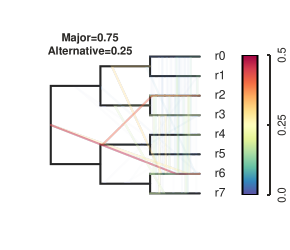

In [283]:
# draw all edges on major networks
c, a, m = BALTREE.draw(height=250, width=290, admixture_edges=major_top_gt2_1e3_df.plot_admix.to_list(),
                      fixed_order=NAME_ORDER);
# add colorbar
numberline = c.numberline(250, 195, 250, 55, min=0, max=0.5)
numberline.colormap(cmap, width=15, style={"stroke-width": 2, "stroke": "black"})
numberline.axis.ticks.locator = toyplot.locator.Explicit(locations=[0.0, 0.25, 0.50], labels=[0.0, 0.25, 0.50])
numberline.axis.ticks.show = True
numberline.axis.ticks.near = False
numberline.axis.ticks.style["stroke-width"] = 2
numberline.axis.spine.style["stroke-width"] = 2
numberline.axis.ticks.labels.style["font-size"] = 11
# add text major vs. alternative network topology
c.text(90,45,
    "<b>Major=0.75</b><br/><b>Alternative=0.25</b>",
    style={"font-size":"11px"},
);
toyplot.svg.render(c, "./nb8_output/plot-net-variable-gt-1e3-bal.svg")
c

In [215]:
# compute means
hist_major_mean = np.mean(major_top_gt2_1e3_df.gamma[major_top_gt2_1e3_df["gamma"] != 0].values)
hist_minor_mean = np.mean(alt_top_gt2_1e3_df.gamma[alt_top_gt2_1e3_df["gamma"] != 0].values)
print(hist_major_mean, hist_minor_mean)

0.07688108108108106 0.12397599999999999


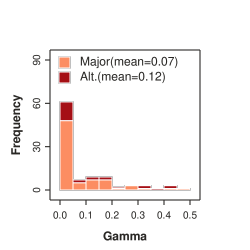

In [216]:
# stacked version
hist_major = np.histogram(major_top_gt2_1e3_df.gamma[major_top_gt2_1e3_df["gamma"] != 0].values, range=(0, 0.5), bins=10)
hist_minor = np.histogram(alt_top_gt2_1e3_df.gamma[alt_top_gt2_1e3_df["gamma"] != 0].values, range=(0, 0.5), bins=10)
major_minor_stack_counts = np.column_stack((hist_major[0], hist_minor[0]))

c = toyplot.Canvas(width=250, height=250)
a = c.cartesian()
bars = a.bars((major_minor_stack_counts), 
              along="x",
              color=[colors[1], colors2[1]])
a.x.label.text = "Gamma"
a.y.label.text = "Frequency"
toytree.utils.set_axes_ticks_external(a)
toytree.utils.set_axes_box_outline(a)
a.x.ticks.locator = toyplot.locator.Explicit(locations=[-0.5,1.5,3.5,5.5,7.5,9.5], labels=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5])
c.style["stroke.width"]=8
a.y.domain.max=90
c.legend([
    ("Major(mean=0.07)", bars.markers[0]),
    ("Alt.(mean=0.12)", bars.markers[1]),
    ],
    bounds=(70, 80, 55, 85),
    );
toyplot.svg.render(c, "./nb8_output/plot-hist-gamma-variable-gt-1e3-bal.svg")
c

### Variable gt, 1e5

In [253]:
snaq_gt2_1e5_parse_df_run1, snaq_gt2_1e5_parse_df_nonzero_run1, snaq_gt2_1e5_admix_run1 = parse_networks("./nb8_output/snaq-gt2-1e5/analysis-snaq/")
snaq_gt2_1e5_parse_df_run2, snaq_gt2_1e5_parse_df_nonzero_run2, snaq_gt2_1e5_admix_run2 = parse_networks("./nb8_output/snaq-gt2-1e5-run2/analysis-snaq/")
snaq_gt2_1e5_parse_df_nonzero_ALL = pd.concat([snaq_gt2_1e5_parse_df_nonzero_run1, snaq_gt2_1e5_parse_df_nonzero_run2])
snaq_gt2_1e5_parse_df_nonzero_ALL.head()

,net,trees,admix,src_node,dest_node,pos_as_prop,pos_as_prop_rand,gamma,plot_admix
0,snaq-gt2-1e5-6-snaq-p386337.snaq.net-1.networks,"(r6:1,(((r2:1,r3:1):7.14016208295e-06,(r0:1,r1:1):1.68588751034):0.122150864885,(r4:1,r5:1):1.85136708878):0.0265393097299,r7:1);","[([r0, r1], [r4, r5], 0.5, {}, 0.403)]","[r0, r1]","[r4, r5]",0.5,0.798619,0.403,"([r0, r1], [r4, r5], 0.7986188502631312, {'stroke': (0.94956863, 0.41639216, 0.26556863, 1.), 'stroke-opacity': '0.403', 'stroke-width': 2})"
1,snaq-gt2-1e5-34-snaq-p386337.snaq.net-1.networks,"(r1:1,(((r4:1,r5:1):1.84860502688,(r7:1,r6:1.161306991):0.0546440383675):0.0991638958128,(r2:1,r3:1):0.0683812174243):1.86777410108,r0:1);","[([r2, r3], [r6], 0.5, {}, 0.169)]","[r2, r3]",[r6],0.5,0.338661,0.169,"([r2, r3], [r6], 0.33866065504313514, {'stroke': (0.7585098, 0.90243137, 0.6252549, 1.), 'stroke-opacity': '0.169', 'stroke-width': 2})"
2,snaq-gt2-1e5-7-snaq-p386337.snaq.net-1.networks,"(r1:1,(((r4:1,r5:1):1.80767016156,(r7:1,r6:1.00302232444):0.0680242122288):0.105998609524,(r2:1,r3:1):0.0923323411383):1.76992111925,r0:1);","[([r2, r3], [r6], 0.5, {}, 0.26)]","[r2, r3]",[r6],0.5,0.718603,0.260,"([r2, r3], [r6], 0.7186025095400747, {'stroke': (0.99921569, 0.97568627, 0.70823529, 1.), 'stroke-opacity': '0.26', 'stroke-width': 2})"
3,snaq-gt2-1e5-8-snaq-p386337.snaq.net-1.networks,"(r7:1,(((r2:1,r3:1):0,(r0:1,r1:1):1.99690089503):0.137886026059,(r4:1,r5:1):1.87477697704):0.0264502069302,r6:1);","[([r0, r1], [r4, r5], 0.5, {}, 0.324)]","[r0, r1]","[r4, r5]",0.5,0.809676,0.324,"([r0, r1], [r4, r5], 0.8096760652118409, {'stroke': (0.99419608, 0.78431373, 0.46603922, 1.), 'stroke-opacity': '0.324', 'stroke-width': 2})"
4,snaq-gt2-1e5-18-snaq-p386337.snaq.net-1.networks,"(r1:1,((r2:1,r3:2):0.0583452374797,((r4:1,r5:1):1.81643463094,(r6:1,r7:1.2877692494):0.0312995666439):0.0943468665274):1.8214337139,r0:1);","[([r3], [r7], 0.5, {}, 0.101)]",[r3],[r7],0.5,0.783563,0.101,"([r3], [r7], 0.7835634649076898, {'stroke': (0.40541176, 0.76290196, 0.64698039, 1.), 'stroke-opacity': '0.101', 'stroke-width': 2})"


In [254]:
major_top_gt2_1e5_df, alt_top_gt2_1e5_df, alt_top_prop_gt2_1e5 = count_alt_topology_prop(snaq_gt2_1e5_parse_df_nonzero_ALL, baltree_2_gt)
alt_top_prop_gt2_1e5

0.1836734693877551

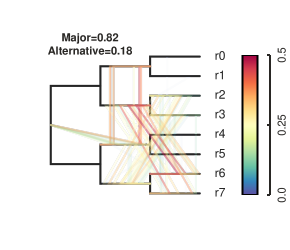

In [285]:
# draw all edges on major networks
c, a, m = BALTREE.draw(height=250, width=290, admixture_edges=major_top_gt2_1e5_df.plot_admix.to_list(),
                      fixed_order=NAME_ORDER);
# add colorbar
numberline = c.numberline(250, 195, 250, 55, min=0, max=0.5)
numberline.colormap(cmap, width=15, style={"stroke-width": 2, "stroke": "black"})
numberline.axis.ticks.locator = toyplot.locator.Explicit(locations=[0.0, 0.25, 0.50], labels=[0.0, 0.25, 0.50])
numberline.axis.ticks.show = True
numberline.axis.ticks.near = False
numberline.axis.ticks.style["stroke-width"] = 2
numberline.axis.spine.style["stroke-width"] = 2
numberline.axis.ticks.labels.style["font-size"] = 11
# add text major vs. alternative network topology
c.text(90,45,
    "<b>Major=0.82</b><br/><b>Alternative=0.18</b>",
    style={"font-size":"11px"},
);
toyplot.svg.render(c, "./nb8_output/plot-net-variable-gt-1e5-bal.svg")
c

In [220]:
# compute means
hist_major_mean = np.mean(major_top_gt2_1e5_df.gamma[major_top_gt2_1e5_df["gamma"] != 0].values)
hist_minor_mean = np.mean(alt_top_gt2_1e5_df.gamma[alt_top_gt2_1e5_df["gamma"] != 0].values)
print(hist_major_mean, hist_minor_mean)

0.18749875 0.24583333333333338


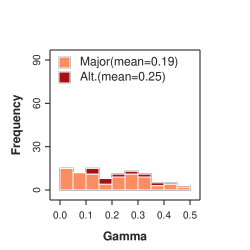

In [221]:
# stacked version
hist_major = np.histogram(major_top_gt2_1e5_df.gamma[major_top_gt2_1e5_df["gamma"] != 0].values, range=(0, 0.5), bins=10)
hist_minor = np.histogram(alt_top_gt2_1e5_df.gamma[alt_top_gt2_1e5_df["gamma"] != 0].values, range=(0, 0.5), bins=10)
major_minor_stack_counts = np.column_stack((hist_major[0], hist_minor[0]))

c = toyplot.Canvas(width=250, height=250)
a = c.cartesian()
bars = a.bars((major_minor_stack_counts), 
              along="x",
              color=[colors[1], colors2[1]])
a.x.label.text = "Gamma"
a.y.label.text = "Frequency"
toytree.utils.set_axes_ticks_external(a)
toytree.utils.set_axes_box_outline(a)
a.x.ticks.locator = toyplot.locator.Explicit(locations=[-0.5,1.5,3.5,5.5,7.5,9.5], labels=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5])
c.style["stroke.width"]=8
a.y.domain.max=90
c.legend([
    ("Major(mean=0.19)", bars.markers[0]),
    ("Alt.(mean=0.25)", bars.markers[1]),
    ],
    bounds=(70, 80, 55, 85),
    );
toyplot.svg.render(c, "./nb8_output/plot-hist-gamma-variable-gt-1e5-bal.svg")
c

### Variable Ne, 1e3

In [256]:
snaq_ne2_1e3_parse_df_run1, snaq_ne2_1e3_parse_df_nonzero_run1, snaq_ne2_1e3_admix_run1 = parse_networks("./nb8_output/snaq-ne2-1e3/analysis-snaq/")
snaq_ne2_1e3_parse_df_run2, snaq_ne2_1e3_parse_df_nonzero_run2, snaq_ne2_1e3_admix_run2 = parse_networks("./nb8_output/snaq-ne2-1e3-run2/analysis-snaq/")
snaq_ne2_1e3_parse_df_nonzero_ALL = pd.concat([snaq_ne2_1e3_parse_df_nonzero_run1, snaq_ne2_1e3_parse_df_nonzero_run2])
snaq_ne2_1e3_parse_df_nonzero_ALL.head()

,net,trees,admix,src_node,dest_node,pos_as_prop,pos_as_prop_rand,gamma,plot_admix
0,snaq-ne2-1e3-35-snaq-p280816.snaq.net-1.networks,"(((r2:1,r3:1):0.0236883305818,((r6:1,r7:1):0.00726487550975,(r5:1,r4:1.04912882465):0.375928738421):0.0418453686683):0.395881005468,r0:1,r1:2);","[([r1], [r4], 0.5, {}, 0.0243)]",[r1],[r4],0.5,0.163473,0.0243,"([r1], [r4], 0.16347259154647065, {'stroke': (0.28476863, 0.41843922, 0.68675294, 1.), 'stroke-opacity': '0.0243', 'stroke-width': 2})"
1,snaq-ne2-1e3-37-snaq-p280816.snaq.net-1.networks,"(((r2:1,r3:1):0.010416781605,((r4:1,r5:1):0.378247613121,(r6:1,r7:1):0.0197420793258):0.0511061622961):0.381436987865,r0:1,r1:5.21451456489);","[([r6, r7], [r1], 0.5, {}, 0.0116)]","[r6, r7]",[r1],0.5,0.224072,0.0116,"([r6, r7], [r1], 0.22407197914172894, {'stroke': (0.32859608, 0.36166275, 0.65985882, 1.), 'stroke-opacity': '0.0116', 'stroke-width': 2})"
2,snaq-ne2-1e3-16-snaq-p280816.snaq.net-1.networks,"(((r2:1,r3:1):0.0186724648079,((r6:1,r7:1):0.0105951719175,(r4:1,r5:1.17721364763):0.39137291031):0.033943963779):0.436589714258,r0:1,r1:2);","[([r1], [r5], 0.5, {}, 0.0273)]",[r1],[r5],0.5,0.914728,0.0273,"([r1], [r5], 0.9147282516665091, {'stroke': (0.27441569, 0.43185098, 0.69310588, 1.), 'stroke-opacity': '0.0273', 'stroke-width': 2})"
3,snaq-ne2-1e3-9-snaq-p280816.snaq.net-1.networks,"(((r2:1,r3:1):0.0073722762277,((r5:1,r4:2):0.393213021291,(r6:1,r7:1):0.012372329763):0.0425840013859):0.400781144595,r0:1,r1:1.01896480914);","[([r4], [r1], 0.5, {}, 0.0184)]",[r4],[r1],0.5,0.306804,0.0184,"([r4], [r1], 0.3068035484529229, {'stroke': (0.30512941, 0.39206275, 0.67425882, 1.), 'stroke-opacity': '0.0184', 'stroke-width': 2})"
4,snaq-ne2-1e3-32-snaq-p280816.snaq.net-1.networks,"(r1:1,((r3:1,r2:1.01481087069):0.0146246437222,(r7:1,(r6:1,(r4:1,r5:1):0.741965093148):0.0252422487648):0.054268002194):0.383617934596,r0:1);","[([r4, r5], [r2], 0.5, {}, 0.412)]","[r4, r5]",[r2],0.5,0.567215,0.4120,"([r4, r5], [r2], 0.5672154290541047, {'stroke': (0.92768627, 0.38321569, 0.27403922, 1.), 'stroke-opacity': '0.412', 'stroke-width': 2})"


In [257]:
major_top_ne2_1e3_df, alt_top_ne2_1e3_df, alt_top_prop_ne2_1e3 = count_alt_topology_prop(snaq_ne2_1e3_parse_df_nonzero_ALL, baltree_2_ne)
alt_top_prop_ne2_1e3

0.14285714285714285

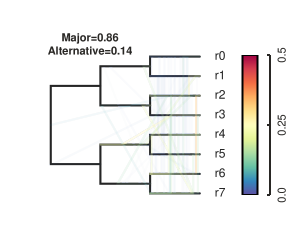

In [286]:
# draw all edges on major networks
c, a, m = BALTREE.draw(height=250, width=290, admixture_edges=major_top_ne2_1e3_df.plot_admix.to_list(),
                      fixed_order=NAME_ORDER);
# add colorbar
numberline = c.numberline(250, 195, 250, 55, min=0, max=0.5)
numberline.colormap(cmap, width=15, style={"stroke-width": 2, "stroke": "black"})
numberline.axis.ticks.locator = toyplot.locator.Explicit(locations=[0.0, 0.25, 0.50], labels=[0.0, 0.25, 0.50])
numberline.axis.ticks.show = True
numberline.axis.ticks.near = False
numberline.axis.ticks.style["stroke-width"] = 2
numberline.axis.spine.style["stroke-width"] = 2
numberline.axis.ticks.labels.style["font-size"] = 11
# add text major vs. alternative network topology
c.text(90,45,
    "<b>Major=0.86</b><br/><b>Alternative=0.14</b>",
    style={"font-size":"11px"},
);
toyplot.svg.render(c, "./nb8_output/plot-net-variable-ne-1e3-bal.svg")
c

In [225]:
# compute means
hist_major_mean = np.mean(major_top_ne2_1e3_df.gamma[major_top_ne2_1e3_df["gamma"] != 0].values)
hist_minor_mean = np.mean(alt_top_ne2_1e3_df.gamma[alt_top_ne2_1e3_df["gamma"] != 0].values)
print(hist_major_mean, hist_minor_mean)

0.05696869047619048 0.11477857142857142


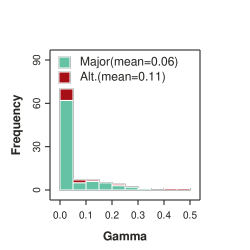

In [226]:
# stacked version
hist_major = np.histogram(major_top_ne2_1e3_df.gamma[major_top_ne2_1e3_df["gamma"] != 0].values, range=(0, 0.5), bins=10)
hist_minor = np.histogram(alt_top_ne2_1e3_df.gamma[alt_top_ne2_1e3_df["gamma"] != 0].values, range=(0, 0.5), bins=10)
major_minor_stack_counts = np.column_stack((hist_major[0], hist_minor[0]))

c = toyplot.Canvas(width=250, height=250)
a = c.cartesian()
bars = a.bars((major_minor_stack_counts), 
              along="x",
              color=[colors[0], colors2[1]])
a.x.label.text = "Gamma"
a.y.label.text = "Frequency"
toytree.utils.set_axes_ticks_external(a)
toytree.utils.set_axes_box_outline(a)
a.x.ticks.locator = toyplot.locator.Explicit(locations=[-0.5,1.5,3.5,5.5,7.5,9.5], labels=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5])
c.style["stroke.width"]=8
a.y.domain.max=90
c.legend([
    ("Major(mean=0.06)", bars.markers[0]),
    ("Alt.(mean=0.11)", bars.markers[1]),
    ],
    bounds=(70, 80, 55, 85),
    );
toyplot.svg.render(c, "./nb8_output/plot-hist-gamma-variable-ne-1e3-bal.svg")
c

### Variable Ne, 1e5

In [259]:
snaq_ne2_1e5_parse_df_run1, snaq_ne2_1e5_parse_df_nonzero_run1, snaq_ne2_1e5_admix_run1 = parse_networks("./nb8_output/snaq-ne2-1e5/analysis-snaq/")
snaq_ne2_1e5_parse_df_run2, snaq_ne2_1e5_parse_df_nonzero_run2, snaq_ne2_1e5_admix_run2 = parse_networks("./nb8_output/snaq-ne2-1e5-run2/analysis-snaq/")
snaq_ne2_1e5_parse_df_nonzero_ALL = pd.concat([snaq_ne2_1e5_parse_df_nonzero_run1, snaq_ne2_1e5_parse_df_nonzero_run2])
snaq_ne2_1e5_parse_df_nonzero_ALL.head()

,net,trees,admix,src_node,dest_node,pos_as_prop,pos_as_prop_rand,gamma,plot_admix
0,snaq-ne2-1e5-8-snaq-p386337.snaq.net-1.networks,"(r1:1,((r2:1,r3:3.75648078439):0.154709132349,((r7:1,r6:1):0.119919708304,(r4:1,r5:1):4.22696052486):0.176561095199):3.88048832143,r0:1);","[([r3], [r4, r5], 0.5, {}, 0.0661)]",[r3],"[r4, r5]",0.5,0.767259,0.06610,"([r3], [r4, r5], 0.7672586028439486, {'stroke': (0.26174118, 0.60657255, 0.71087059, 1.), 'stroke-opacity': '0.0661', 'stroke-width': 2})"
1,snaq-ne2-1e5-38-snaq-p386337.snaq.net-1.networks,"(((r2:1,r3:1.16896842018):0.12513421512,((r4:1,r5:1):4.02374713273,(r6:1,r7:1):0.134474241157):0.150032497943):4.77990820527,r0:1,r1:2);","[([r1], [r3], 0.5, {}, 0.00906)]",[r1],[r3],0.5,0.334900,0.00906,"([r1], [r3], 0.33489962312704735, {'stroke': (0.33736157, 0.35030745, 0.65448, 1.), 'stroke-opacity': '0.00906', 'stroke-width': 2})"
2,snaq-ne2-1e5-3-snaq-p386337.snaq.net-1.networks,"(r1:1,(((r4:1,r5:1):3.99234107624,(r7:1,r6:1.30979790112):0.146890638459):0.169398029374,(r2:1,r3:1):0.160978902354):4.03199170716,r0:1);","[([r2, r3], [r6], 0.5, {}, 0.0401)]","[r2, r3]",[r6],0.5,0.655769,0.04010,"([r2, r3], [r6], 0.6557693255071925, {'stroke': (0.23024314, 0.48907451, 0.72021176, 1.), 'stroke-opacity': '0.0401', 'stroke-width': 2})"
3,snaq-ne2-1e5-47-snaq-p386337.snaq.net-1.networks,"(r1:1,((r3:1,r2:1.1420542365):0.142138215938,((r4:1,r5:1):3.8012000963,(r6:1,r7:1):1.13267123621):0.172243175376):3.88935785119,r0:1);","[([r6, r7], [r2], 0.5, {}, 0.0628)]","[r6, r7]",[r2],0.5,0.010382,0.06280,"([r6, r7], [r2], 0.010381764308026842, {'stroke': (0.24828235, 0.59156078, 0.71708235, 1.), 'stroke-opacity': '0.0628', 'stroke-width': 2})"
4,snaq-ne2-1e5-39-snaq-p386337.snaq.net-1.networks,"(r1:1,r0:1,((r3:1,r2:2):0.134805095305,((r6:1,r7:1):0.128660113303,(r4:1,r5:1):3.98055617582):0.157709857325):3.99770557766);","[([r2], [r3, r2, r6, r7, r4, r5], 0.5, {}, 0.0603)]",[r2],"[r3, r2, r6, r7, r4, r5]",0.5,0.246460,0.06030,"([r2], [r3, r2, r6, r7, r4, r5], 0.2464604281556413, {'stroke': (0.23808627, 0.58018824, 0.72178824, 1.), 'stroke-opacity': '0.0603', 'stroke-width': 2})"


In [260]:
major_top_ne2_1e5_df, alt_top_ne2_1e5_df, alt_top_prop_ne2_1e5 = count_alt_topology_prop(snaq_ne2_1e5_parse_df_nonzero_ALL, baltree_2_ne)
alt_top_prop_ne2_1e5

0.030303030303030304

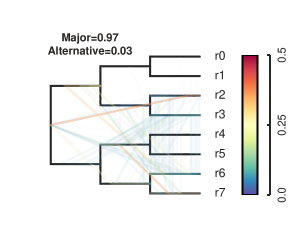

In [287]:
# draw all edges on major networks
c, a, m = BALTREE.draw(height=250, width=290, admixture_edges=major_top_ne2_1e5_df.plot_admix.to_list(),
                      fixed_order=NAME_ORDER);
# add colorbar
numberline = c.numberline(250, 195, 250, 55, min=0, max=0.5)
numberline.colormap(cmap, width=15, style={"stroke-width": 2, "stroke": "black"})
numberline.axis.ticks.locator = toyplot.locator.Explicit(locations=[0.0, 0.25, 0.50], labels=[0.0, 0.25, 0.50])
numberline.axis.ticks.show = True
numberline.axis.ticks.near = False
numberline.axis.ticks.style["stroke-width"] = 2
numberline.axis.spine.style["stroke-width"] = 2
numberline.axis.ticks.labels.style["font-size"] = 11
# add text major vs. alternative network topology
c.text(90,45,
    "<b>Major=0.97</b><br/><b>Alternative=0.03</b>",
    style={"font-size":"11px"},
);
toyplot.svg.render(c, "./nb8_output/plot-net-variable-ne-1e5-bal.svg")
c

In [230]:
# compute means
hist_major_mean = np.mean(major_top_ne2_1e5_df.gamma[major_top_ne2_1e5_df["gamma"] != 0].values)
hist_minor_mean = np.mean(alt_top_ne2_1e5_df.gamma[alt_top_ne2_1e5_df["gamma"] != 0].values)
print(hist_major_mean, hist_minor_mean)

0.0562440625 0.4163333333333333


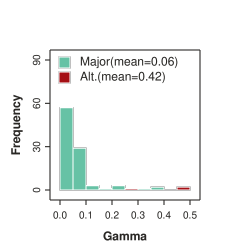

In [231]:
# stacked version
hist_major = np.histogram(major_top_ne2_1e5_df.gamma[major_top_ne2_1e5_df["gamma"] != 0].values, range=(0, 0.5), bins=10)
hist_minor = np.histogram(alt_top_ne2_1e5_df.gamma[alt_top_ne2_1e5_df["gamma"] != 0].values, range=(0, 0.5), bins=10)
major_minor_stack_counts = np.column_stack((hist_major[0], hist_minor[0]))

c = toyplot.Canvas(width=250, height=250)
a = c.cartesian()
bars = a.bars((major_minor_stack_counts), 
              along="x",
              color=[colors[0], colors2[1]])
a.x.label.text = "Gamma"
a.y.label.text = "Frequency"
toytree.utils.set_axes_ticks_external(a)
toytree.utils.set_axes_box_outline(a)
a.x.ticks.locator = toyplot.locator.Explicit(locations=[-0.5,1.5,3.5,5.5,7.5,9.5], labels=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5])
c.style["stroke.width"]=8
a.y.domain.max=90
c.legend([
    ("Major(mean=0.06)", bars.markers[0]),
    ("Alt.(mean=0.42)", bars.markers[1]),
    ],
    bounds=(70, 80, 55, 85),
    );
toyplot.svg.render(c, "./nb8_output/plot-hist-gamma-variable-ne-1e5-bal.svg")
c

### Unlinked gt

In [262]:
snaq_gt_unlinked_bal_parse_df, snaq_gt_unlinked_bal_parse_df_nonzero, snaq_gt_unlinked_bal_admix = parse_networks("./nb8_output/snaq-true-gt-unlinked-bal/analysis-snaq/")
snaq_gt_unlinked_bal_parse_df_nonzero.head()

,net,trees,admix,src_node,dest_node,pos_as_prop,pos_as_prop_rand,gamma,plot_admix
0,snaq-true-gt-unlinked-bal-60-snaq-p2622290.snaq.net-1.networks,"(r1:1,((r2:1,r3:1):0.0159223096205,((r4:1,r5:2):0.33906219379,(r6:1,r7:5.05981497886):0.0160085103069):0.0271811419621):0.334146873683,r0:1);","[([r5], [r7], 0.5, {}, 0.00895)]",[r5],[r7],0.5,0.905746,0.00895,"([r5], [r7], 0.9057456971570631, {'stroke': (0.33774118, 0.34981569, 0.65424706, 1.), 'stroke-opacity': '0.00895', 'stroke-width': 2})"
1,snaq-true-gt-unlinked-bal-29-snaq-p2622290.snaq.net-1.networks,"((r3:1,((r4:1,r5:1):0.337407523415,(r7:1,r6:1.03772014755):0.00736656055361):0.0381396166471):0.0113218960455,r2:1,(r0:1,r1:1):0.296650430492);","[([r0, r1], [r6], 0.5, {}, 0.221)]","[r0, r1]",[r6],0.5,0.510859,0.22100,"([r0, r1], [r6], 0.5108589020874558, {'stroke': (0.94313725, 0.9772549, 0.66031373, 1.), 'stroke-opacity': '0.221', 'stroke-width': 2})"
2,snaq-true-gt-unlinked-bal-35-snaq-p2622290.snaq.net-1.networks,"(r1:1,((r2:1,r3:3.43910536555):0.0295744431129,((r6:1,r7:1):0.00710526406985,(r4:1,r5:1):0.331193203722):0.0397035695824):0.32733248679,r0:1);","[([r4, r5], [r3], 0.5, {}, 0.0186)]","[r4, r5]",[r3],0.5,0.351394,0.01860,"([r4, r5], [r3], 0.3513942989608392, {'stroke': (0.30443922, 0.39295686, 0.67468235, 1.), 'stroke-opacity': '0.0186', 'stroke-width': 2})"
3,snaq-true-gt-unlinked-bal-51-snaq-p2622290.snaq.net-1.networks,"((r7:1,(r6:1,((r1:1,r0:1):0.320312420177,(r2:1,r3:1):0.0202115139764):0.0430816319951):0.00494600460071):0.476277321714,r5:1,r4:2);","[([r4], [r2, r3], 0.5, {}, 0.251)]",[r4],"[r2, r3]",0.5,0.391198,0.25100,"([r4], [r2, r3], 0.3911983578778172, {'stroke': (0.99992157, 0.99756863, 0.74494118, 1.), 'stroke-opacity': '0.251', 'stroke-width': 2})"
4,snaq-true-gt-unlinked-bal-75-snaq-p2622290.snaq.net-1.networks,"(r4:1,((r6:1,r7:1):0.0148254876336,((r0:1,r1:2):0.342048465637,(r3:1,r2:5.59577520641):0.0213087192197):0.016074814698):0.337959387368,r5:1);","[([r1], [r2], 0.5, {}, 0.0215)]",[r1],[r2],0.5,0.238449,0.02150,"([r1], [r2], 0.2384493157289691, {'stroke': (0.29443137, 0.40592157, 0.68082353, 1.), 'stroke-opacity': '0.0215', 'stroke-width': 2})"


In [263]:
major_top_true_gt_unlinked_bal_df, alt_top_true_gt_unlinked_bal_df, alt_top_prop_true_gt_unlinked_bal = count_alt_topology_prop(snaq_gt_unlinked_bal_parse_df_nonzero, baltree_2_gt)
alt_top_prop_true_gt_unlinked_bal

0.23

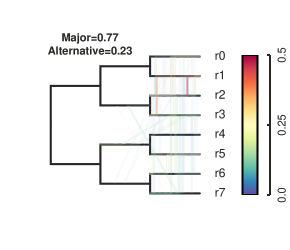

In [315]:
# draw all edges on major networks
c, a, m = BALTREE.draw(height=250, width=290, admixture_edges=major_top_true_gt_unlinked_bal_df.plot_admix.to_list(),
                      fixed_order=NAME_ORDER);
# add colorbar
numberline = c.numberline(250, 195, 250, 55, min=0, max=0.5)
numberline.colormap(cmap, width=15, style={"stroke-width": 2, "stroke": "black"})
numberline.axis.ticks.locator = toyplot.locator.Explicit(locations=[0.0, 0.25, 0.50], labels=[0.0, 0.25, 0.50])
numberline.axis.ticks.show = True
numberline.axis.ticks.near = False
numberline.axis.ticks.style["stroke-width"] = 2
numberline.axis.spine.style["stroke-width"] = 2
numberline.axis.ticks.labels.style["font-size"] = 11
# add text major vs. alternative network topology
c.text(90,45,
    "<b>Major=0.77</b><br/><b>Alternative=0.23</b>",
    style={"font-size":"11px"},
);
toyplot.svg.render(c, "./nb8_output/plot-net-unlinked-gt-bal.svg")
c

In [238]:
# compute means
hist_major_mean = np.mean(major_top_true_gt_unlinked_bal_df.gamma[major_top_true_gt_unlinked_bal_df["gamma"] != 0].values)
hist_minor_mean = np.mean(alt_top_true_gt_unlinked_bal_df.gamma[alt_top_true_gt_unlinked_bal_df["gamma"] != 0].values)
print(hist_major_mean, hist_minor_mean)

0.06925636363636366 0.19033478260869566


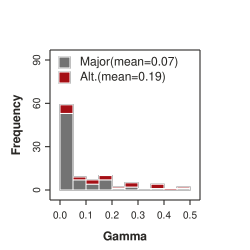

In [316]:
# stacked version
hist_major = np.histogram(major_top_true_gt_unlinked_bal_df.gamma[major_top_true_gt_unlinked_bal_df["gamma"] != 0].values, range=(0, 0.5), bins=10)
hist_minor = np.histogram(alt_top_true_gt_unlinked_bal_df.gamma[alt_top_true_gt_unlinked_bal_df["gamma"] != 0].values, range=(0, 0.5), bins=10)
major_minor_stack_counts = np.column_stack((hist_major[0], hist_minor[0]))

c = toyplot.Canvas(width=250, height=250)
a = c.cartesian()
bars = a.bars((major_minor_stack_counts), 
              along="x",
              color=[colors3[3], colors2[1]])
a.x.label.text = "Gamma"
a.y.label.text = "Frequency"
toytree.utils.set_axes_ticks_external(a)
toytree.utils.set_axes_box_outline(a)
a.x.ticks.locator = toyplot.locator.Explicit(locations=[-0.5,1.5,3.5,5.5,7.5,9.5], labels=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5])
c.style["stroke.width"]=8
a.y.domain.max=90
c.legend([
    ("Major(mean=0.07)", bars.markers[0]),
    ("Alt.(mean=0.19)", bars.markers[1]),
    ],
    bounds=(70, 80, 55, 85),
    );
toyplot.svg.render(c, "./nb8_output/plot-hist-gamma-unlinked-gt-bal.svg")
c

### Unlinked Ne

In [265]:
snaq_ne_unlinked_bal_parse_df, snaq_ne_unlinked_bal_parse_df_nonzero, snaq_ne_unlinked_bal_admix = parse_networks("./nb8_output/snaq-true-ne-unlinked-bal/analysis-snaq/")
snaq_ne_unlinked_bal_parse_df_nonzero.head()

,net,trees,admix,src_node,dest_node,pos_as_prop,pos_as_prop_rand,gamma,plot_admix
0,snaq-true-ne-unlinked-bal-57-snaq-p2622290.snaq.net-1.networks,"((r2:1,(r3:1,((r6:1,r7:1):0.00956055592891,(r4:1,r5:1.13578977385):0.347660783336):0.0413887882592):0.00385121074502):0.344160670048,r1:1,r0:2);","[([r0], [r5], 0.5, {}, 0.0394)]",[r0],[r5],0.5,0.585087,0.0394,"([r0], [r5], 0.585087487546902, {'stroke': (0.23265882, 0.4859451, 0.71872941, 1.), 'stroke-opacity': '0.0394', 'stroke-width': 2})"
1,snaq-true-ne-unlinked-bal-90-snaq-p2622290.snaq.net-1.networks,"(r1:1,(r2:1,(((r6:1,r7:1):0.00551765508637,(r5:1,r4:1.11769971689):0.324231989159):0.043487464874,r3:2):0.00460478511297):0.352485768609,r0:1);","[([r3], [r4], 0.5, {}, 0.0176)]",[r3],[r4],0.5,0.790311,0.0176,"([r3], [r4], 0.7903106492653696, {'stroke': (0.3078902, 0.38848627, 0.67256471, 1.), 'stroke-opacity': '0.0176', 'stroke-width': 2})"
2,snaq-true-ne-unlinked-bal-97-snaq-p2622290.snaq.net-1.networks,"(((r6:1,r7:1):0.00328528004718,(r4:1,r5:1):0.337152461348):0.0426090494018,r3:1,(r2:1,(r0:1,r1:1):0.325484176606):0.000176082570437);","[([r2, r0, r1], [r4, r5], 0.5, {}, 0.254)]","[r2, r0, r1]","[r4, r5]",0.5,0.413501,0.2540,"([r2, r0, r1], [r4, r5], 0.41350123175975106, {'stroke': (0.99968627, 0.99027451, 0.73270588, 1.), 'stroke-opacity': '0.254', 'stroke-width': 2})"
3,snaq-true-ne-unlinked-bal-78-snaq-p2622290.snaq.net-1.networks,"(((r1:1,r0:1):0.337113673216,((r6:1,r7:1):0.0134263771742,(r5:1,r4:1.29594301542):0.346112081207):0.0277920666465):0.0245043767598,r2:1,r3:2);","[([r3], [r4], 0.5, {}, 0.0426)]",[r3],[r4],0.5,0.776635,0.0426,"([r3], [r4], 0.7766353194806417, {'stroke': (0.22161569, 0.50025098, 0.72550588, 1.), 'stroke-opacity': '0.0426', 'stroke-width': 2})"
4,snaq-true-ne-unlinked-bal-48-snaq-p2622290.snaq.net-1.networks,"(r1:1,((r3:1,r2:1):0.0161670125643,((r7:1,r6:2):0.0263019326698,(r4:1,r5:1.51837720719):0.340382520403):0.0231988269117):0.331968003752,r0:1);","[([r6], [r5], 0.5, {}, 0.0246)]",[r6],[r5],0.5,0.800031,0.0246,"([r6], [r5], 0.8000309076671178, {'stroke': (0.28373333, 0.41978039, 0.68738824, 1.), 'stroke-opacity': '0.0246', 'stroke-width': 2})"


In [266]:
major_top_true_ne_unlinked_bal_df, alt_top_true_ne_unlinked_bal_df, alt_top_prop_true_ne_unlinked_bal = count_alt_topology_prop(snaq_ne_unlinked_bal_parse_df_nonzero, baltree_2_ne)
alt_top_prop_true_ne_unlinked_bal

0.29

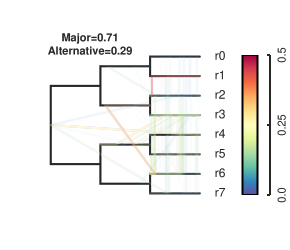

In [289]:
# draw all edges on major networks
c, a, m = BALTREE.draw(height=250, width=290, admixture_edges=major_top_true_ne_unlinked_bal_df.plot_admix.to_list(),
                      fixed_order=NAME_ORDER);
# add colorbar
numberline = c.numberline(250, 195, 250, 55, min=0, max=0.5)
numberline.colormap(cmap, width=15, style={"stroke-width": 2, "stroke": "black"})
numberline.axis.ticks.locator = toyplot.locator.Explicit(locations=[0.0, 0.25, 0.50], labels=[0.0, 0.25, 0.50])
numberline.axis.ticks.show = True
numberline.axis.ticks.near = False
numberline.axis.ticks.style["stroke-width"] = 2
numberline.axis.spine.style["stroke-width"] = 2
numberline.axis.ticks.labels.style["font-size"] = 11
# add text major vs. alternative network topology
c.text(90,45,
    "<b>Major=0.71</b><br/><b>Alternative=0.29</b>",
    style={"font-size":"11px"},
);
toyplot.svg.render(c, "./nb8_output/plot-net-unlinked-ne-bal.svg")
c

In [246]:
# compute means
hist_major_mean = np.mean(major_top_true_ne_unlinked_bal_df.gamma[major_top_true_ne_unlinked_bal_df["gamma"] != 0].values)
hist_minor_mean = np.mean(alt_top_true_ne_unlinked_bal_df.gamma[alt_top_true_ne_unlinked_bal_df["gamma"] != 0].values)
print(hist_major_mean, hist_minor_mean)

0.08375929577464789 0.13645862068965517


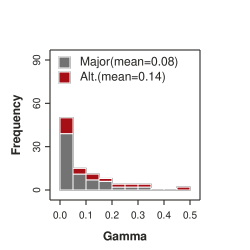

In [247]:
# stacked version
hist_major = np.histogram(major_top_true_ne_unlinked_bal_df.gamma[major_top_true_ne_unlinked_bal_df["gamma"] != 0].values, range=(0, 0.5), bins=10)
hist_minor = np.histogram(alt_top_true_ne_unlinked_bal_df.gamma[alt_top_true_ne_unlinked_bal_df["gamma"] != 0].values, range=(0, 0.5), bins=10)
major_minor_stack_counts = np.column_stack((hist_major[0], hist_minor[0]))

c = toyplot.Canvas(width=250, height=250)
a = c.cartesian()
bars = a.bars((major_minor_stack_counts), 
              along="x",
              color=[colors3[3], colors2[1]])
a.x.label.text = "Gamma"
a.y.label.text = "Frequency"
toytree.utils.set_axes_ticks_external(a)
toytree.utils.set_axes_box_outline(a)
a.x.ticks.locator = toyplot.locator.Explicit(locations=[-0.5,1.5,3.5,5.5,7.5,9.5], labels=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5])
c.style["stroke.width"]=8
a.y.domain.max=90
c.legend([
    ("Major(mean=0.08)", bars.markers[0]),
    ("Alt.(mean=0.14)", bars.markers[1]),
    ],
    bounds=(70, 80, 55, 85),
    );
toyplot.svg.render(c, "./nb8_output/plot-hist-gamma-unlinked-ne-bal.svg")
c